# Проведение и анализ А/B теста для интернет магазина

**Описание проекта**

Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты. 

**Описание данных**

*Данные для первой части*

Файл `/datasets/hypothesis.csv`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

*Данные для второй части*

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Цели проекта**
- Приоритезация гипотез с помощью фреймворков ICE и RICE, выбор гипотезы для проведения A/B-теста
- Оценка результатов A/B-теста с помощью анализа таких метрик как кумулятивная выручка, кумулятивный средний чек, а также среднее количество заказов на посетителя (конверсия)

**Задачи, выполняемые в ходе проекта**

- Применение фреймворка ICE для приоритизации гипотез
- Применение фреймворка RICE для приоритизации гипотез
- Анализ измений приоритизации гипотез при применении RICE вместо ICE
- Построение графика кумулятивной выручки по группам
- Построение графика кумулятивного среднего чека по группам
- Построение графика относительного изменения кумулятивного среднего чека группы B к группе A
- Построение графика кумулятивного среднего количества заказов на посетителя по группам
- Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
- Анализ данных на аномалии
- Расчет границ аномалий в данных
- Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным
- Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным
- Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
- Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным
- Принятие решения по результатам теста

**Навигация по работе**

[***Часть 1. Приоритезация гипотез***](#1)

[***1.1 Загрузка и предобработка данных***](#2)

[***1.2 Применение фреймворка ICE***](#3)

[***1.3 Применение фреймворка RICE***](#4)

[***Часть 2. Анализ А/В-теста***](#5)

[***2.1 Загрузка и предобработка данных***](#6)

[***2.2 График куммулятивной выручки по группам***](#7)

[***2.3 График куммулятивного среднего чека по группам***](#8)

[***2.4 График относительного изменения кумулятивного среднего чека группы B к группе A***](#9)

[***2.5 График кумулятивного среднего количества заказов на посетителя по группам***](#10)

[***2.6 График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A***](#11)

[***2.7 Анализ аномалий***](#12)

[***2.8 Расчет статистической значимости по сырым данным***](#13)

[***2.9 Расчет статистической значимости по очищенным данным***](#14)

[***Решение по результатам теста***](#15)

<a id ='1'></a>
## Часть 1. Приоритезация гипотез

<a id ='2'></a>
### Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [2]:
# загрузка данных 
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
# функция для первичного анализа датасета
def df_info(df, n=5):
    print(f'---------- Первые {n} строк датафрейма ----------')
    display(df.head(n))
    print('---------- Общая информация о датафрейме ----------\n')
    display(df.info())
    print('---------- Статистическая сводка ----------')
    display(df.describe())
    print('---------- Пропуски ----------')
    display(df.isna().sum())
    print('---------- Процент пропусков от общего числа строк ----------')
    display(df.isna().mean().sort_values(ascending=False) * 100)
    if df.duplicated().sum() > 0:
        print(f'---------- Количество дубликатов: {df.duplicated().sum()} ----------')
    else:
        print('---------- Дубликаты отсутствуют ----------')

In [4]:
df_info(hypothesis)

---------- Первые 5 строк датафрейма ----------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

---------- Статистическая сводка ----------


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


---------- Пропуски ----------


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64

---------- Дубликаты отсутствуют ----------


In [5]:
# приведем названия столбцов к правильному формату
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Из обзора датафрейма с информацией о гипотезах можно отметить:
- в датафрейме присутствуют 5 столбцов и 9 строк;
- типы данных у всех столбцов датафрейма установлены верно, в корректировке не нуждаются;
- пропуски отсутствуют;
- дубликаты отсустствуют;
- названия столбцов приведены к нижнему регистру.

В целом в датафрейме данные качественные, замечаний по ним нет, можно приступать к приоритезации гипотез.

In [6]:
# настроим вывод гипотез полностью
pd.options.display.max_colwidth = 150
hypothesis['hypothesis']

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

<a id ='3'></a>
### Применение фреймворка ICE

In [7]:
# рассчитаем ICE
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
# выведем рейтинг гипотез в зависимости от показателя ICE
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Больше всего очков набрали гипотезы "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	", тогда как меньше всего очков набрали гипотезы "Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар" и "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей". Посмотрим за счет каких показателей эти гипотезы получили свои очки.

In [8]:
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" обладает почти максимальными характеристиками **impact** и **confidence**, что неудивительно, ведь с полной уверенностью можно сказать, что скидка на товар оказывает сильное влияние на пользователя; параметр **efforts**, отвечающий за сложность проверки гипотезы, здесь на среднем уровне. 

Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" находится на самом последнем месте в рейтинге, так как все параметры этой гипотезы минимальны. Действительно, сложно сказать, что изменение цвета фона главной страницы как-то повлияет на вовлеченность пользователей. Хотя проверить эту гипотезу легко, вряд ли это имеет смысл.

<a id ='4'></a>
### Применение фреймворка RICE

In [9]:
# рассчитаем RICE
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['ICE']
# выведем рейтинг гипотез в зависимости от показателя RICE
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Рейтинг гипотез значительно изменился: больше всего очков набрали гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". Гипотеза "Запустить акцию, дающую скидку на товар в день рождения", которая лидировала в прошлом рейтинге, теперь занимает лишь 5 место.

In [10]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" имеет достаточно большие показатели **impact** и **confidence**. Показатель охвата пользователей **reach** у данной гипотезы максимальный, что и позволило ей стать приорететной для дальнейшего анализа. Действительно, добавление форм подписки на все основные страницы охватывает большое количество пользователей, при этом оказывая достаточно сильное влияние: собирается база клиентов для email-рассылок; сложность проверки данной гипотезы средняя, а показатель уверенности высокий на основании данных эскпертов.

Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" опустилась в рейтинге из-за слишком низкго показателя **reach**, что неудивительно: акция, дающая скидку на товар в день рождения охватывает каждого пользователя только 1 раз в году в определенную дату.

**Вывод:** поработав с фреймворками ICE и RICE, можно отметить, что учет охвата пользователей может оказать существенное влияние на приоритезацию гипотез.

Параметр **reach** и, соответственно, фремйворк RICE следует использовать тогда, когда для анализа важна степень охвата пользователей гипотезой, и этот параметр можно объективно оценить.

Для проведения A/B-теста выберем следующую гипотезу: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

<a id ='5'></a>
## Часть 2. Анализ A/B-теста

<a id ='6'></a>
### Загрузка и предобработка данных

In [11]:
# загрузка данных 
try:
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [12]:
# первичный анализ датасета с информацией о заказах
df_info(orders)

---------- Первые 5 строк датафрейма ----------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

---------- Статистическая сводка ----------


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


---------- Пропуски ----------


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

---------- Дубликаты отсутствуют ----------


In [13]:
# первичный анализ датасетса с информацией о визитах
df_info(visitors)

---------- Первые 5 строк датафрейма ----------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

---------- Статистическая сводка ----------


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


---------- Пропуски ----------


date        0
group       0
visitors    0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


date        0.0
group       0.0
visitors    0.0
dtype: float64

---------- Дубликаты отсутствуют ----------


In [14]:
# приведение даты к нужному формату
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [15]:
# приведение названий столбцов к корректному виду
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверим на неявные дубликаты столбцы с данными о группах

In [16]:
print('Группы в orders:', orders['group'].unique())
print('Группы в visitors:', visitors['group'].unique())

Группы в orders: ['B' 'A']
Группы в visitors: ['A' 'B']


Из обзора данных можно отметить следующее:

Датафрейм ``orders``:
- 5 столбцов и 1197 строк;
- пропуски отсутствуют;
- дубликаты отсутствуют;
- столбец с датой приведен к нужному формату, больше корректировки типа данных столбцов не требуется;
- названия столбцов приведены к правильному формату.

Датафрейм ``visitors``:
- 3 столбца, 62 строки;
- пропуски отсутствуют;
- дубликаты отсутствуют;
- столбец с датой приведен к нужному формату, больше корректировки типа данных столбцов не требуется;
- названия столбцов в правильном формате.

В целом в датафреймах данные качественные, можно приступать к анализу A/B-теста.

### График кумулятивной выручки по группам <a id ='7'></a>

Создадим датафреймы с уникальными агрегироваными кумулятивными данными по таблицам с информацией о заказах и посетителях:

In [17]:
# создаем массив уникальных пар значений дат и групп теста
dt_groups = orders[['date', 'group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dt_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dt_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'
         }
    ),
    axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим график куммулятивной выручки по дням и группам

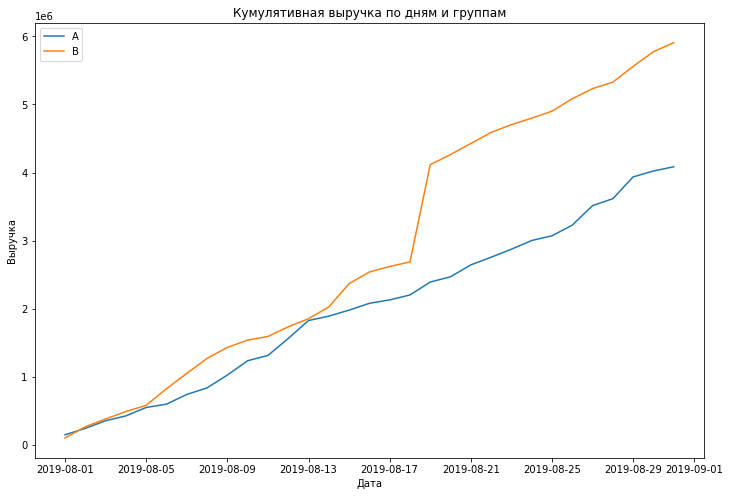

In [18]:
# задаем размер графику
plt.figure(figsize=(12,8))

# строим график кумулятивной выручки по дням и групам
sns.lineplot(data = cumulative_data, x = "date", y = "revenue", hue='group')

# выводим легенду, задаем название и подписи осей графику
plt.legend()
plt.title('Кумулятивная выручка по дням и группам')
plt.ylabel('Выручка')
plt.xlabel('Дата');

Исходя из графика можно сделать вывод, что выручка почти равномерно увеличивается на протяжении всего теста. При этом на протяжении всего теста кумулятивная выручка группы B превышает кумулятивную выручку группы A.

Также стоит отметить, что выручка группы B резко растет с 18 на 19 августа 2019 года. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Выясним причину резкого повышения выручки группы B. Для этого построим график кумулятивного количества заказов группы B.

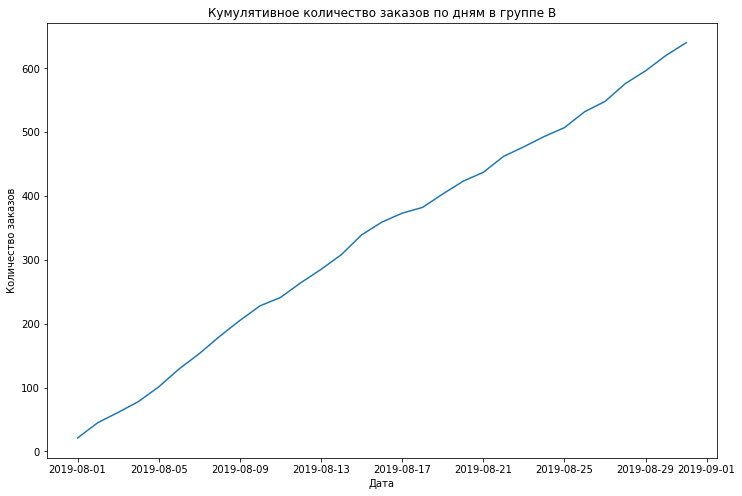

In [19]:
# задаем размер графику
plt.figure(figsize=(12,8))

# строим график кумулятивной выручки по дням и групам
sns.lineplot(data = cumulative_data[cumulative_data['group']=='B'], x = "date", y = "orders")

# задаем название и подписи осей графику
plt.title('Кумулятивное количество заказов по дням в группе B')
plt.ylabel('Количество заказов')
plt.xlabel('Дата');

По графику видно, что кумулятивное количество заказов группы B повышается равномерно, без неожиданных всплесков, а следовательно можем сделать вывод о том, что в группу попал аномально дорогой заказ.

### График кумулятивного среднего чека по группам <a id ='8'></a>

Для того, чтобы построить график кумуятивного среднего чека по группам разделим кумулятивную выручку на кумулятивное количество заказов

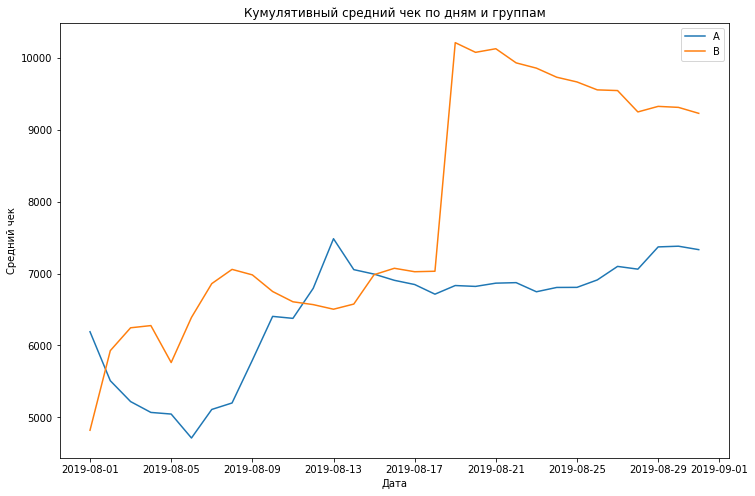

In [20]:
# задаем размер графику
plt.figure(figsize=(12,8))

# строим график кумулятивного среднего чека по дням и группам
sns.lineplot(data = cumulative_data, x = "date", y = cumulative_data['revenue'] / cumulative_data['orders'], hue='group')

# выводим легенду, задаем название и подписи осей графику
plt.legend()
plt.title('Кумулятивный средний чек по дням и группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата');

Из графика следует:
- первую половину теста средние чеки обоих групп ведут себя нестабильно, характеризуются резкими подъемами и спадами;
- наблюдается резкое увеличение среднего чека группы B в период с 17.08 до 21.08, что еще раз подтверждает наличие выявленных аномалий в стоимости заказов в этот период;
- к концу периода кумулятивный средний чек группы B значительно превышает кумулятивный средний чек, однако это может быть следствием аномалий в стоимости заказов;
- к концу периода средний чек группы B имеет тенденцию к снижению, а группы A - к повышению.

### График относительного изменения кумулятивного среднего чека группы B к группе A <a id ='9'></a>

Для начала создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням для каждой группы отдельно, а затем соберем полученные данные в одном датафрейме

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b,
                                                        left_on='date',
                                                        right_on='date',
                                                        how='left',
                                                        suffixes=['_a', '_b'])
merged_cumulative_revenue.head()

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим график относительного изменения кумулятивного среднего чека группы В к группе А. Для этого кумулятвный средний чек группы В разделим на кумулятивный средний чек группы А, а затем отнимем из частного единицу

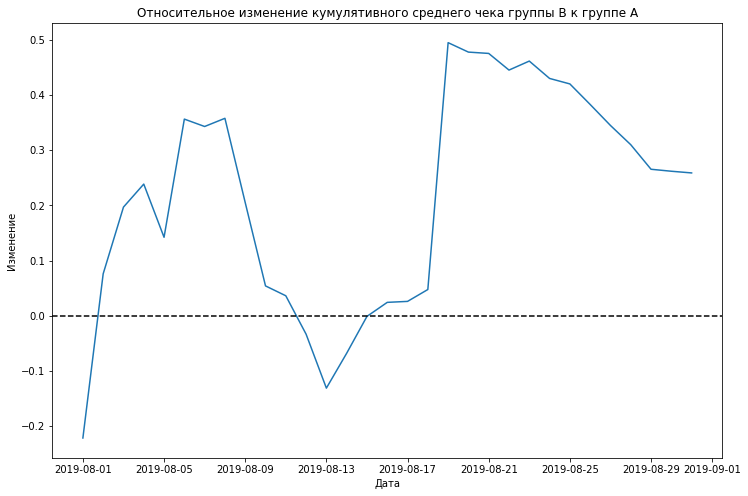

In [22]:
# задаем размер графику
plt.figure(figsize=(12,8))

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenue_b'] / merged_cumulative_revenue['orders_b']) / 
         (merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# задаем название и подписи осей графику
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Изменение')
plt.xlabel('Дата');

На графике можно заметить резкие скачки среднего чека, что может свидетельствовать о том, что в эти дни были совершены аномально дорогие заказы, влияющие на результат теста. Также можно сделать вывод о том, что результаты группы В не зафиксировались около среднего значения.

### График кумулятивного среднего количества заказов на посетителя по группам <a id ='10'></a>

Для того, чтобы проанализировать среднее количество заказов на посетителя по группам сначала разделим количество заказов на количество посетителей для каждой даты, то есть просчитаем конверсию посетителей в покупателей. Затем построим график данной метрики по группам

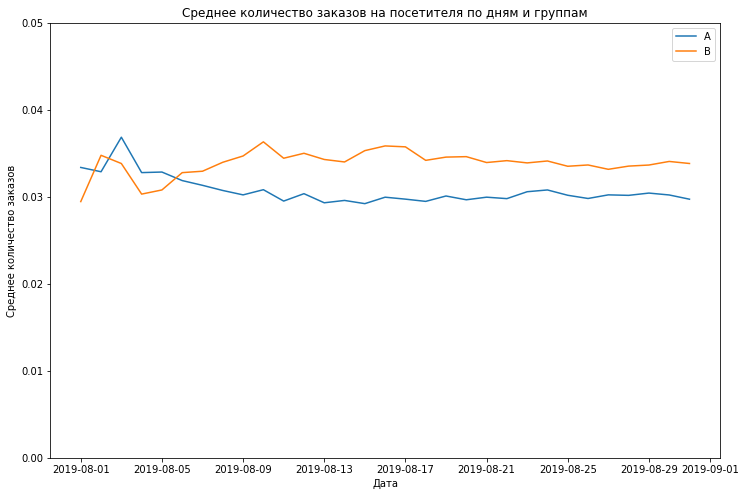

In [23]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# задаем размеры графика
plt.figure(figsize=(12,8))

# строим график среднего количества заказов на посетителя
sns.lineplot(data=cumulative_data, x='date', y='conversion', hue='group')

# задаем масштаб осu
plt.axis(ymin = 0 , ymax=0.05) 
# выводим легенду, задаем название и подписи осей графику
plt.legend()
plt.title('Среднее количество заказов на посетителя по дням и группам')
plt.ylabel('Среднее количество заказов')
plt.xlabel('Дата');

Среднее количество заказов на посетителя группы В вырвалось вперед через 5 дней после начала теста и зафиксировалось около среднего, а у группы А - просело, однако тоже зафиксировалось. В целом можно сказать, что по среднему количеству заказов на посетителя группа B более успешна, чем группа А, однако разница в конверсии между группами небольшая - менее 0,01

 ### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A <a id ='11'></a>
 
 Для построения графика сначала разделим данные конверсии по группам, а затем соберем их в один датафрейм для более удобного проведения дальнейших манипуляций с данными 

In [24]:
# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'conversion']]
# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'conversion']]
# объединяем данные
merged_conversion = cumulative_data_a.merge(cumulative_data_b,
                                            left_on='date',
                                            right_on='date',
                                            how='left',
                                            suffixes=['_a', '_b'])
merged_conversion.head()

,date,conversion_a,conversion_b
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Построим график относительного изменения конверсии группы В к группе А. Для этого разделим конверсию группы В на конверсию группы А, а затем отнимем от частного единицу, чтобы анализировать именно прирост конверсии

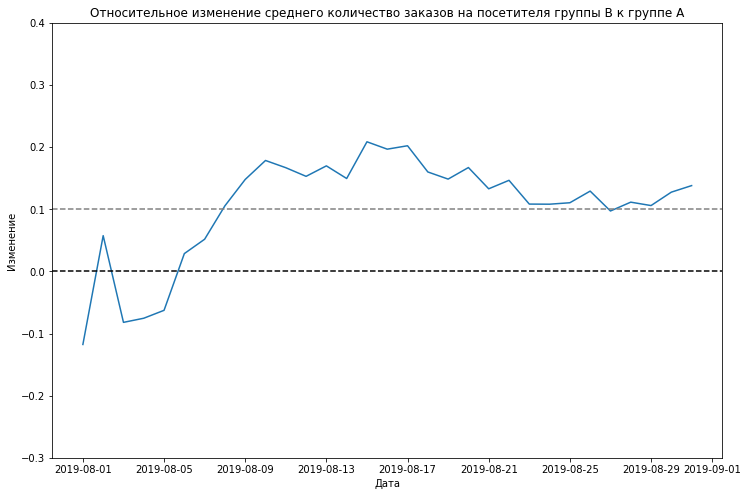

In [25]:
# задаем размер графика
plt.figure(figsize=(12,8))

# строим график относительного изменения среднего количества заказов на посетителя группы B к группе А
plt.plot(merged_conversion['date'], merged_conversion['conversion_b'] / merged_conversion['conversion_a'] - 1)

# задаем горизонтальные линии
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

# задаем масштаб оси у
plt.axis(ymin = -0.3 , ymax=0.4) 

# задаем название и подписи осей графику
plt.title('Относительное изменение среднего количество заказов на посетителя группы B к группе А')
plt.ylabel('Изменение')
plt.xlabel('Дата');

Из графика видно, что изначально группа В проигрывала группе А по среднему количеству заказов на посетителя, однако затем вырвалась вперед и зафиксировалась около среднего, превышая конверсию группы А более чем на 0,1

### Анализ аномалий <a id ='12'></a>

Сначала проанализируем **количество заказов** на аномалии. 

Выясним наиболее наиболее часто встречающееся количество заказов, определим границу, от которой начинаются выбросы, чтобы в дальнейшем во время статистического анализа "очистить" данные

In [26]:
# датафрейм с количеством заказов для каждого пользователя и указанием группы этого пользователя
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique',
           'group' : 'max'})
)

# меняем название столбцов дф
orders_by_users.columns = ['user_id', 'transactions', 'group']

orders_by_users.sort_values(by='transactions', ascending=False).head(10)

,user_id,transactions,group
1023,4256040402,11,B
591,2458001652,11,B
569,2378935119,9,B
487,2038680547,8,B
44,199603092,5,B
744,3062433592,5,B
55,237748145,5,B
917,3803269165,5,B
299,1230306981,5,B
897,3717692402,5,B


Уже на данном этапе можно отметить большое количество заказов у некоторый пользователей: 8, 9, 11 заказов - это аномально высокие значения

Оценим распределение количества заказов с помощью точечной диаграммы и определим границы нормальных значений

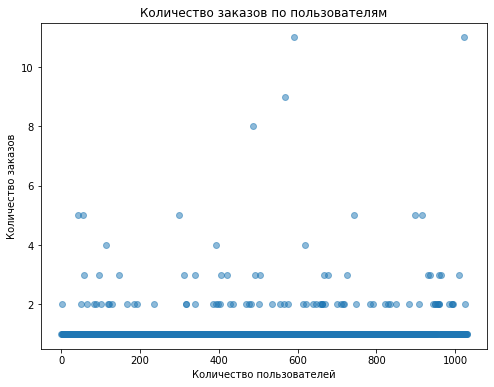

In [27]:
# задаем размер графика
plt.figure(figsize=(8, 6))

# строим точечный график количества заказов по пользователям
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['transactions'], alpha=0.5)

# задаем название и подписи осей графику
plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей');

Большинство пользователей делают 1-2 заказа, есть немного пользователей с аномально большим количеством заказов: от 3-х до 5-ти заказов уже редко встречаются, однако есть пользователи и с 11-ю заказами. Наверняка у магазина есть постоянные и крупные заказчики, так что эти аномалии - не ошибка в данных, однако их все равно стоит убрать для того, чтобы не исказить результаты A/B-теста.

Рассчитаем 95-й и 99-й перцентиль для установления точной границы аномальных значений

In [28]:
print('95-й перцентиль:', *np.percentile(orders_by_users['transactions'], [95]))
      
print('99-й перцентиль:', *np.percentile(orders_by_users['transactions'], [99]))

95-й перцентиль: 2.0
99-й перцентиль: 4.0


- Не более 5% пользователей совершили более 2-х заказов;
- не более 1% пользователей совершили более 4-х заказов.

Из этого можем определить границу аномальных значений: при проведении статистического анализа "очистим" данные от пользователей, которые совершили более 3-х заказов. Так мы потеряем менее 5% процентов данных

Теперь проверим на аномалии **стоимости сделанных заказов**

Выясним наиболее характерную стоимость заказа, определим границу, от которой начинаются выбросы, чтобы в дальнейшем во время статистического анализа "очистить" данные

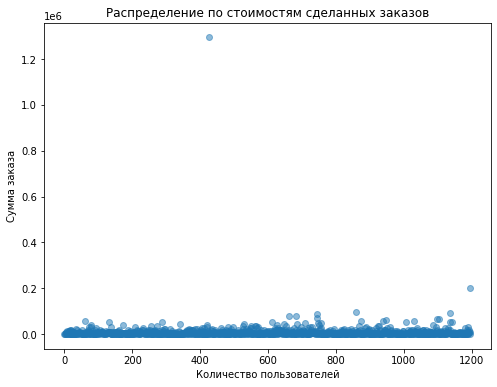

In [29]:
# задаем размер графику
plt.figure(figsize=(8,6))

# строим точечный график распределения стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.5) 

# задаем название и подписи осей графику
plt.title('Распределение по стоимостям сделанных заказов')
plt.ylabel('Сумма заказа')
plt.xlabel('Количество пользователей');

Основная масса стоимостей заказов распределена около 100 тыс. д.е., однако по графику уже заметны очевидные аномалии: наблюдается заказ свыше 1,2 млн. д.е. 

Ограничим график до 150 тыс. д.е., чтобы подробнее изучить распределение

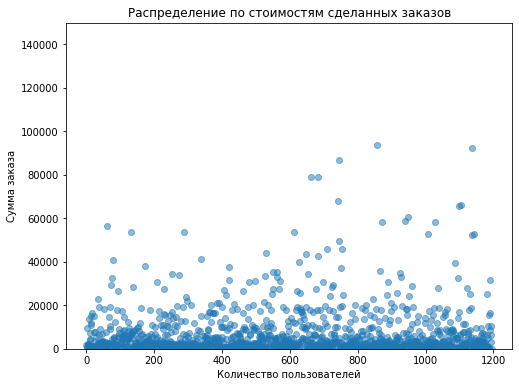

In [30]:
# задаем размер графику
plt.figure(figsize=(8,6))

# строим точечный график распределения стоимостей заказов
plt.scatter(x_values, orders['revenue'], alpha=0.5) 

# задаем название и подписи осей графику
plt.title('Распределение по стоимостям сделанных заказов')
plt.ylabel('Сумма заказа')
plt.xlabel('Количество пользователей')
plt.ylim(0, 150000);

Отметим, что в основном стоимости заказов распределены около 20 тыс. д.е., наблюдаются выбросы. Определим 95-й и 99-й перцентили для того, чтобы обозначить границу аномально дорогих заказов

In [31]:
print('95-й перцентиль:', round(*np.percentile(orders['revenue'], [95])))
      
print('99-й перцентиль:', round(*np.percentile(orders['revenue'], [99])))

95-й перцентиль: 28000
99-й перцентиль: 58233


- Не более 5% заказов со стоимостью более 28000;
- не более 1% заказов со стоимостью более 58233.

Из этого можем определить границу аномальных значений: при проведении статистического анализа "очистим" данные от заказов со стоимостью более чем 30000. Так мы потеряем менее 5% процентов данных

### Расчет статистической значимости по сырым данным <a id ='13'></a>

**Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами**

Для начала подготовим данные: создадим датафреймы по группам с информацией о заказах для каждого пользователя, который совершил хотя бы один заказ

In [32]:
# таблица с данными о заказах пользователей, совершивших хоть один заказ, в группе А
orders_by_users_a = orders_by_users[orders_by_users['group'] == 'A'][['user_id', 'transactions']]
orders_by_users_a.columns = ['user_id', 'transactions']

# таблица с данными о заказах пользователей, совершивших хоть один заказ, в группе B
orders_by_users_b = orders_by_users[orders_by_users['group'] == 'B'][['user_id', 'transactions']]
orders_by_users_b.columns = ['user_id', 'transactions'] 

display(orders_by_users_a.head())
orders_by_users_b.head()

,user_id,transactions
3,11685486,1
7,54447517,1
9,66685450,1
12,78758296,1
13,85103373,1


,user_id,transactions
0,5114589,1
1,6958315,1
2,8300375,2
4,39475350,1
5,47206413,1


Затем объявим переменные, в которых пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов — нули

In [33]:
#таблица с данными о кол-ве заказов всех пользователе в группе А
sample_a = pd.concat([
        orders_by_users_a['transactions'],
        pd.Series(0, 
                  index=np.arange
                  (visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['transactions'])
                  ),
                  name='orders')],axis=0)


#таблица с данными о кол-ве заказов всех пользователе в группе В
sample_b = pd.concat([
        orders_by_users_b['transactions'],
        pd.Series
        (0,
         index=np.arange(
             visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['transactions'])
        ),
         name='orders')],axis=0)

Данные для проведения теста Манна-Уитни подготовлены, сформируем гипотезу.

**Нулевая гипотеза:** Различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет

**Алтернативная гипотеза:** Различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть

In [34]:
# задаем уровень стат. значимости
alpha = 0.05

# применим критерий
result_1 = stats.mannwhitneyu(sample_a, sample_b)[1]

# выводим p-value
print('Значение p-value:', '{0:.5f}'.format(result_1))

print('\nOтносительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

if result_1 < alpha:
    print("\nОтвергаем нулевую гипотезу")
else:
    print("\nНе получилось отвергнуть нулевую гипотезу") 

Значение p-value: 0.00001

Oтносительный прирост среднего числа заказов группы B: 0.543

Отвергаем нулевую гипотезу


Полученное значение p-value (0,00001) нам говорит о том, что при условии, что различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть, получить такое или большее различие случайно можно с очень маленькой вероятностью (ниже 0.01%). Эта вероятность слишком мала для того, чтобы делать вывод об отсутствии разницы в среднем количестве заказов на посетителя между группами.

Относительный прирост среднего числа заказов группы B над группой А равен ~54%, что является хорошим показателем, однако есть вероятность влияния аномалий на результат.

**Расчет статистической значимости различий в среднем чеке заказа между группами**

**Нулевая гипотеза:** Различий в среднем чеке заказа между группами по «сырым» данным нет

**Алтернативная гипотеза:** Различия в среднем чеке заказа между группами по «сырым» данным есть

In [35]:
#применим критерий
result_2 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]  

#введем значение p-value
print('Значение p-value :', '{0:.2f}'.format(result_2))

print('\nOтносительный прирост в среднем чеке группы B:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

if result_2 < alpha:
    print("\nОтвергаем нулевую гипотезу")
else:
    print("\nНе получилось отвергнуть нулевую гипотезу")  

Значение p-value : 0.73

Oтносительный прирост в среднем чеке группы B: 0.259

Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value (0,73) говорит о том, что хотя различия в среднем чеке заказа между группами и есть, с вероятностью в 73% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками, поэтому мы не можем отвергнуть нулевую гипотезу.

Относительный прирост в среднем чеке группы B над группой А равен 26%, что служит хорошим показателем, однако есть вероятность влияния на средний чек аномальных значений.

### Расчет статистической значимости по очищенным данным <a id ='14'></a>

**Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами**

Для начала "очистим" данные:

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 30 000 д.е., так мы уберём от 1%  до 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

In [36]:
# собираем пользователей с большим кол-вом заказов 
many_orders = orders_by_users[orders_by_users['transactions'] > 3]['user_id']

# собираем пользователей с слишком дорогими заказами
expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

# объединяем всё в один датафрейм 
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print('\nКол-во анoмальных пользователей: ', abnormal_users.shape[0])

1099    148427295
44      199603092
928     204675465
55      237748145
684     358944393
dtype: int64

Кол-во анoмальных пользователей:  61


Всего 61 аномальный пользователь. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [38]:
#отфильтруем данные в группе А 
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#отфильтруем данные в группе В
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)  

sample_a_filtered.head()

3     1
7     1
9     1
12    1
13    1
dtype: int64

Данные для проведения теста Манна-Уитни подготовлены, гипотезы остались те же:

**Нулевая гипотеза:** Различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет

**Алтернативная гипотеза:** Различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть

In [39]:
# применим критерий
result_3 = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]

# выводим p-value
print('Значение p-value:', '{0:.5f}'.format(result_3))

print('\nOтносительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

if result_1 < alpha:
    print("\nОтвергаем нулевую гипотезу")
else:
    print("\nНе получилось отвергнуть нулевую гипотезу") 

Значение p-value: 0.00019

Oтносительный прирост среднего числа заказов группы B: 0.355

Отвергаем нулевую гипотезу


Для "очищенных" данных также справедливо уверждение о том, что мы отвергаем нулевую гипотезу. При условии, что различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть, получить такое или большее различие случайно можно с чуть большей (0.019%) вероятностью, чем по "сырым" данным (0,001%), однако эта вероятность все еще слишком мала для того, чтобы делать вывод об отсутствии разницы в среднем количестве заказов на посетителя между группами.

Относительный прирост среднего количества заказов в группе B по сравнению с группой А составляет примерно 35%. Это значение почти на 20% меньше, чем прирост, рассчитанный на основе исходных данных. Влияние аномалий на результат теста было исключено, однако показатель остался на высоком уровне.

**Расчет статистической значимости различий в среднем чеке заказа между группами**

**Нулевая гипотеза:** Различий в среднем чеке заказа между группами по «сырым» данным нет

**Алтернативная гипотеза:** Различия в среднем чеке заказа между группами по «сырым» данным есть

In [46]:
# "очистим" данные в группе А
orders_normal_a = orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

# очистим данные в группе В
orders_normal_b = orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

display(orders_normal_a.head())
display(orders_normal_b.head())

2       400
7      1044
8     13710
10     4008
12     7370
Name: revenue, dtype: int64

0    1650
1     730
3    9759
4    2308
5    2210
Name: revenue, dtype: int64

In [47]:
# проведем тест Манна-Уитни
result_4 = stats.mannwhitneyu(orders_normal_a, orders_normal_b)[1] 

#введем значение p-value
print('Значение p-value :', '{0:.2f}'.format(result_4))

print('\nOтносительный прирост в среднем чеке группы B:',
      '{0:.3f}'.format(orders_normal_b.mean()/orders_normal_a.mean()-1)) 

if result_2 < alpha:
    print("\nОтвергаем нулевую гипотезу")
else:
    print("\nНе получилось отвергнуть нулевую гипотезу")  

Значение p-value : 0.82

Oтносительный прирост в среднем чеке группы B: -0.027

Не получилось отвергнуть нулевую гипотезу


Для "очищенных" данных также справедливо утверждение о том, что мы не можем отвергнуть нулевую гипотезу. Значение p-value возросло на 10% по сравнению с первоначальным значением, полученным на основе «сырых» данных. Теперь оно составляет 82% вместо 73%. Это подтверждает, что различия в среднем чеке заказа между группами, вероятно, не являются значимыми. С вероятностью 82% или выше такое различие можно получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками, поэтому мы не можем отвергнуть нулевую гипотезу.

Относительный прирост среднего чека группы B по сравнению с группой А составил -2,7%, что на 28% меньше, чем по исходным данным. Это произошло из-за аномалий. После их удаления прирост стал отрицательным, но небольшим.

### Решение по результатам теста <a id ='15'></a>

По результатам проведения анализа результатов A/B-теста можно отметить, что в группе В значительно возросло среднее количество заказов на покупателя, хотя и средний чек остался на уровне группы А.

Имеющиеся факты:
- Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, есть тенденция к улучшению либо результат зафиксировался около среднего значения;
- График различия среднего чека колеблется и, хотя к концу периода наблюдения тоже показывает, что результаты группы B становятся лучше группы A, результат все еще незафиксировался около среднего, а "очищенные" данные указывают на отсутствие различия между средними чеками двух групп.

**Исходя из обнаруженных фактов, тест следует остановить, признать его успешным и перейти к проверке следующей гипотезы.**